In [1]:
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa

import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms

In [5]:
dataset_folder = '../data/'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

transform = transforms.Compose([
        transforms.Resize([400, 400]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

model = models.resnet18(num_classes=2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([30, 400, 400, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

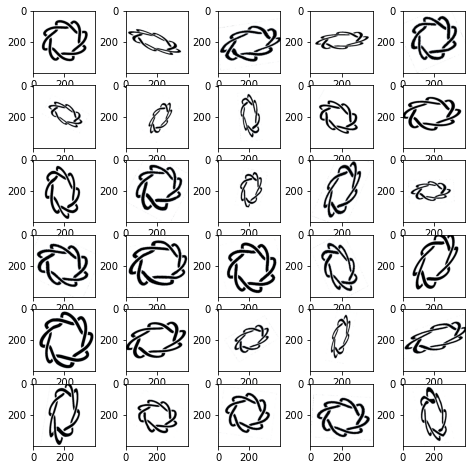

In [7]:
aug_logos_amount = 30
logo_im = transform(Image.open('../data/logo2.jpg')).permute(1, 2, 0).unsqueeze(0)
composed = torch.cat([logo_im for _ in range(aug_logos_amount)], dim=0)
print(composed.shape)

aug = iaa.Sequential([
    iaa.Sometimes(0.7, iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
    iaa.Sometimes(0.7, iaa.PiecewiseAffine(scale=(0.01, 0.05))),
    iaa.Affine(
        scale={"x": (0.3, 1.2), "y": (0.3, 1.2)},
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        rotate=(-30, 30),
        cval=(255),
        shear=(-8, 8)
    )
    # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*100), per_channel=0.5),
], random_order=True)

aug_logos = aug(images = composed.numpy())

fig = plt.figure(figsize=(8, 8))

for i in range(1, aug_logos_amount + 1):
    fig.add_subplot(aug_logos_amount // 5, 5, i)
    plt.imshow(aug_logos[i - 1])

plt.show()

aug_logos_images = torch.Tensor(aug_logos).permute(0, 3, 1, 2).to(device)
aug_logos_labels = torch.ones([aug_logos_amount], dtype=torch.long).to(device)

In [11]:
optimizer = optim.Adam(params=model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [27]:
## Logo pre-training stage

model.train()
torch.cuda.empty_cache()
for epoch in range(5):
    model_output = model(aug_logos_images)

    loss = criterion(model_output, aug_logos_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Loss on epoch {0}: {1}'.format(epoch, loss))

Loss on epoch 0: 9.107467121793889e-06
Loss on epoch 1: 6.198825303727062e-06
Loss on epoch 2: 4.382898623589426e-06
Loss on epoch 3: 3.178898396072327e-06
Loss on epoch 4: 2.3881500510469778e-06


In [18]:
## Main training stage

dataset = datasets.ImageFolder(dataset_folder, transform)
train_loader = DataLoader(dataset , batch_size=30, shuffle=True, pin_memory=device)

model.train()
torch.cuda.empty_cache()
for epoch in range(10):
    epoch_loss = 0
    for step, example in enumerate(train_loader):
        images, labels = example[0].to(device), example[1].to(device)

        model_output = model(images)

        loss = criterion(model_output, labels)
        epoch_loss += loss.item()
        # print('Loss on batch {0}: {1}'.format(step, loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del images, labels, model_output, loss

    print('Avg Loss on epoch {0}: {1}'.format(epoch, epoch_loss / (len(dataset) // 10)))

Avg Loss on epoch 0: 2.058298455344306
Avg Loss on epoch 1: 0.6364452491203944
Avg Loss on epoch 2: 0.5795619213280992
Avg Loss on epoch 3: 1.1797335942586262
Avg Loss on epoch 4: 0.6686810122595893
Avg Loss on epoch 5: 0.25123804807662964
Avg Loss on epoch 6: 0.47442417674594456
Avg Loss on epoch 7: 0.22381391127904257
Avg Loss on epoch 8: 0.2108549028635025
Avg Loss on epoch 9: 0.2729025615586175


In [30]:
model.eval()

test_image = Image.open('../test/dvz.png')
test_image = transform(test_image).to(device)

output = model(test_image.unsqueeze(0))
_, pr = torch.max(output, 1)
print(pr, output)

if pr.item() == 1:
    print('krujok')

tensor([1], device='cuda:0') tensor([[-4.1319,  3.7366]], device='cuda:0', grad_fn=<AddmmBackward>)
